# General Data Visualization
 - Visualize and explore data generally, without digging into any specific opening move(s).

In [2]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from io import TextIOWrapper
from time import sleep
import pandas as pd
import seaborn as sb
import os, gc, json
load_dotenv()

True

In [16]:
db.close()
del db

In [4]:
global db
if 'db' not in globals():
  uri = os.environ.get('mongoConnStr')
  if uri is None:
    uri = "mongodb://localhost:27017"
  print("Mongo Connection String is not set. Falling back to localhost!")
  #try to get explicitly defined connection string, otherwise fallback to localhost.
  
  # Create a new client and connect to the server
  print("Connecting to MongoDB...")
  db = MongoClient(uri, server_api=ServerApi('1'))
  
  # Send a ping to confirm a successful connection
  try:
    db.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
  except Exception as e:
    print(e)
else:
  print("Aren't you alreayd connected?")

Mongo Connection String is not set. Falling back to localhost!
Connecting to MongoDB...


Pinged your deployment. You successfully connected to MongoDB!


In [5]:
db['chessData'].list_collection_names()

['2023-10']

In [6]:
db['chessData']['2023-10'].estimated_document_count()

94724586

In [4]:
cc = db['chessData']['2023-10']
#chessCollection

### Available attributes:
opening, variation, whiteElo, blackElo, winner

In [30]:
#cc.distinct('opening')

### Group by Opening

In [40]:
#gr - group
grOpening = { 
  '$group': {
      '_id': '$opening', 
      'count': {'$sum': 1}
    }
  }

#ag - aggregrated
agOpening = list(cc.aggregate([grOpening]))  


In [ ]:
openingsDf = pd.DataFrame(agOpening)
openingsDf.rename(columns={'_id': 'opening_name'}, inplace=True)
openingsDf.sort_values(by=['count'], ascending=False, inplace=True)
openingsDf.to_csv('TopOpenings.csv', index=False, header=True)

In [ ]:
openingsDf

### Group by Opening AND Variation

In [9]:
grOpeningVariant = { 
  '$group': {
      '_id': {
          'opening': '$opening',
          'variation': '$variation'
      }, 
      'count': {'$sum': 1}
    }
}

agOpeningVariant = list(cc.aggregate([grOpeningVariant]))

In [19]:
openingVariantDf = pd.json_normalize(agOpeningVariant)
openingVariantDf.rename(columns={'_id.opening': 'opening_name', '_id.variation': 'opening_variation'}, inplace=True)
openingVariantDf.sort_values(by=['count'], ascending=False, inplace=True)
openingVariantDf = openingVariantDf[['opening_name', 'opening_variation', 'count']]
openingVariantDf.to_csv('TopOpeningVariants.csv', index=False, header=True)

In [22]:
openingVariantDf

,opening_name,opening_variation,count
346,Queen's Pawn Game,~,2528789
598,Modern Defense,~,2398596
2468,Scandinavian Defense,Mieses-Kotroc Variation,2086035
2759,Caro-Kann Defense,~,2057570
776,Van't Kruijs Opening,~,1738266
...,...,...,...
1615,King's Gambit Accepted,"Lolli Gambit, Young Variation",1
698,Four Knights Game,"Symmetrical, Blake Variation",1
832,Tarrasch Defense,"Classical Variation, Chandler Variation",1
1823,Scotch Game,"Horwitz Attack, Blackburne Variation",1


## Visualization

In [5]:
import pandas as pd
import seaborn as sb
from matplotlib import ticker
import matplotlib.pyplot as plt
sb.set_theme(font="Sarabun", font_scale=0.9)

In [43]:
openingsDf = pd.read_csv('TopOpenings.csv')

In [21]:
openingsDf

,opening_name,opening_count
0,Sicilian Defense,9487601
1,Queen's Pawn Game,7906789
2,French Defense,5613896
3,Scandinavian Defense,5019647
4,Caro-Kann Defense,4799981
...,...,...
151,Venezolana Opening,105
152,Formation,82
153,Dresden Opening,46
154,Veresov Opening,37


In [13]:
#https://stackoverflow.com/a/67237328
def million_formatter(x, pos):
  return f"{round(x / 1e6)}M"

def thousand_formatter(x, pos):
  return f"{round(x / 1e3)}K"

In [ ]:
plot = sb.barplot(x='opening_count', y='opening_name', data=openingsDf.head(10))
plot.set(title="Top 10 Most used opening.", ylabel="", xlabel="Number of games played")
plot.bar_label(plot.containers[0], fmt='{:,.0f}', padding=2)
plot.xaxis.set_major_formatter(million_formatter)
plot.xaxis.set_major_locator(ticker.MultipleLocator(base=2*1e6))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(base=1e6/2))

In [52]:
plot.get_figure().savefig('Top10Openings.png', dpi=300, facecolor='w', bbox_inches='tight')

## Sicilian Defense

In [9]:
openingVariantDf = pd.read_csv('TopOpeningVariants.csv')

In [10]:
siciDf = openingVariantDf[openingVariantDf['opening_name'] == 'Sicilian Defense']

In [11]:
siciDf

,opening_name,opening_variation,count
16,Sicilian Defense,Old Sicilian,860056
17,Sicilian Defense,Bowdler Attack,841342
22,Sicilian Defense,~,690106
29,Sicilian Defense,Closed,531265
31,Sicilian Defense,Smith-Morra Gambit,497327
...,...,...,...
2901,Sicilian Defense,"Dragon Variation, Classical Variation, Zollne...",4
2908,Sicilian Defense,"Kan Variation, Wing Attack, Christiansen's Dream",4
2944,Sicilian Defense,"Sozin Attack, Main Line, Sherbakov Variation",2
2954,Sicilian Defense,"Canal Attack, Dorfman Gambit",1


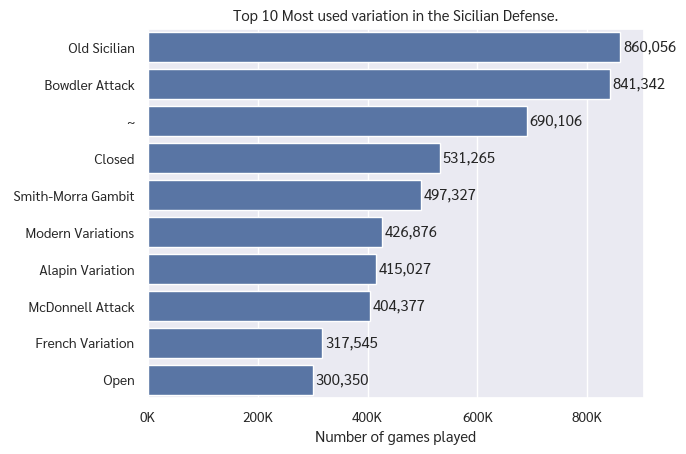

In [14]:
plot = sb.barplot(x='count', y='opening_variation', data=siciDf.head(10))
plot.set(title="Top 10 Most used variation in the Sicilian Defense.", ylabel="", xlabel="Number of games played")
plot.bar_label(plot.containers[0], fmt='{:,.0f}', padding=2)
plot.xaxis.set_major_formatter(thousand_formatter)
plot.xaxis.set_major_locator(ticker.MultipleLocator(base=2*1e5))
plot.xaxis.set_minor_locator(ticker.MultipleLocator(base=1e5/2))

In [15]:
plot.get_figure().savefig('Top10Sici.png', dpi=300, facecolor='w', bbox_inches='tight')